[View in Colaboratory](https://colab.research.google.com/github/tjh48/DCGAN/blob/master/dcgan.ipynb)

First we'll import all the tools we need and set some initial parameters

In [0]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.utils import np_utils
from keras.initializers import RandomNormal
import keras.backend as K
import time


# Just in case we're re-running, clear the Keras session data.
K.clear_session()

# Shall we use BatchNormalization layers?
useBN = False
# Shall we use bias?
useBias = True

# Logging directory and label
LOG_DIR = './log'
logSub = "mnistDCGAN"


This is an optional code block for creating an ngrok tunnel to a tensorboard instance. Useful for running on cloud services 

In [22]:
if not os.path.isfile('./ngrok'):
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip  

get_ipython().system_raw(
    'tensorboard --logdir ' + LOG_DIR + ' --host 0.0.0.0 --port 6006 &'
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://e37a75c1.ngrok.io


This code block imports manual logging functionality and defines a couple of extra functions required for GANs in Keras, since we need to use train_on_batch rather than fit. train_on_batch does not log automatically to tensorboard, hence we'll perform the logging manually.

In [23]:
if os.path.isfile('tensorboard_logging.py'): os.remove('tensorboard_logging.py')
!wget https://gist.githubusercontent.com/tjh48/bf56684801d641544e49a5e66bf15fba/raw/9c6e04cca49288ab0920d9a3aeb3283da13d1a39/tensorboard_logging.py
import tensorboard_logging as tbl  

subdir = LOG_DIR + "/" + logSub + '_' + str(int(np.round(time.time())))
logger = tbl.Logger(subdir)

--2018-08-29 20:50:54--  https://gist.githubusercontent.com/tjh48/bf56684801d641544e49a5e66bf15fba/raw/9c6e04cca49288ab0920d9a3aeb3283da13d1a39/tensorboard_logging.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3783 (3.7K) [text/plain]
Saving to: ‘tensorboard_logging.py’

tensorboard_logging 100%[===================>]   3.69K  --.-KB/s    in 0s      

2018-08-29 20:50:54 (31.6 MB/s) - ‘tensorboard_logging.py’ saved [3783/3783]



Next we'll download the MNIST data set, in lieu of anything more interesting to work with.

We'll also define a function for plotting MNIST-type images so that we can see the output of the generator.

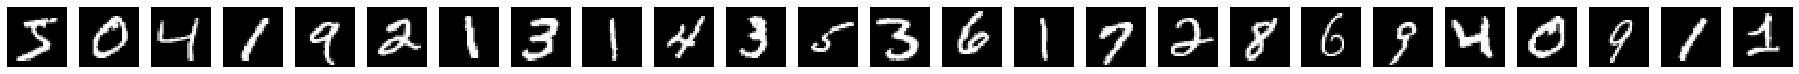

In [24]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

# just for fun, you can drop in the fashion_mnist dataset here instead of standard mnist
#from keras.datasets import fashion_mnist
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 127.5 - 1
x_test = x_test.astype('float32') / 127.5 - 1

x_train = x_train[:, :, :, np.newaxis]

def plotImages(images, n = 25):
  plt.figure(figsize=(32, 32))
  for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    x = images[i]
    if x.shape[2] == 1: x = x.reshape(x.shape[0:2])
    plt.imshow((x + 1) / 2)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()
  
plotImages(x_train)

In [0]:
def genfun(inputLayer, initialFeatures = 256, outputDim = 32, outputFeatures = 3, minimumDim = 5):
  # Here we find the number of times the output dimension is divisible by 2
  # while still keeping the initial dimension of the data above some threshold.
  # Letting the threshold go too low results in model collapse; ad hoc experimentation suggests that
  # an initial dimension >= 5 is ok.
  for loop in range(int(np.log2(outputDim)) + 1):
    if(outputDim % np.power(2, loop) != 0 or outputDim / np.power(2, loop) < minimumDim):
      break
  
  # Given the number of times the output dimension is divisible by 2,
  # we can determine the initial dimension of the dense layer from a random vector.
  initialDim = outputDim // np.power(2, loop - 1)
  if initialDim == outputDim:
    raise ValueError("The outputDim is not divisible by 2 - there's no clean way to upsample.")
  
  x = Dense(initialDim*initialDim*initialFeatures, kernel_initializer='glorot_normal', use_bias = useBias)(inputLayer)
  x = LeakyReLU(0.2)(x)
  if useBN: x = BatchNormalization()(x)
  x = Reshape((initialDim, initialDim, initialFeatures))(x)
  
  # Now we can repeatedly upsample doubling the dimension each time 
  # and convolute, halving the number of features
  # until we arrive at (half the) right output dimension
  for ii in range(loop - 1):
    x = UpSampling2D(size=(2, 2), data_format='channels_last')(x)
    if ii < loop - 2:
      x = Conv2D(initialFeatures // np.power(2, ii + 1), kernel_size = 5, padding ='same', use_bias = useBias, strides = 1)(x)
      x = LeakyReLU(0.2)(x)
      if useBN: x = BatchNormalization()(x)
  # now reduce the features to one (for MNIST) - for colour images we may need three or more channels in output
  x = Conv2D(outputFeatures, kernel_size = 5, padding ='same', use_bias = useBias, strides = 1)(x)
  x = Activation('tanh')(x)
  return x

Here's a function to define the generator layer. We want to upsample from a random vector to an image, with a convolutional layer at each upsampling. Each upsampling with a 2x2 shape doubles the size of the image, so we can start with with a low-dimensional image with a large number of features and upsample until we get to the right size. 

Starting with a too-low dimensional image gives model failure, particularly if you don't use batch normalisation. Ad hoc experimentation suggests that an initial dimension > 5 is required to avoid this scenario.


And here's a function to define a discriminator layer. In the original DCGAN paper, this is envisaged as an almost direct mirror image of the generator. It need not be - we could have fewer layers (to make the discriminator less efficient) as long as we end with a dense layer mapping to a single output.

In [0]:
def disfun(inputImage, initialFeatures= 64, numLayers = 2):
  x = inputImage
  for ii in range(numLayers):
    x = Conv2D(initialFeatures * np.power(2, ii), kernel_size = 5, padding='same', strides=(2,2), use_bias = useBias)(x)
    x = LeakyReLU(0.2)(x)
    if useBN: x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dense(1, activation = 'sigmoid', use_bias = useBias)(x)
  return x

Now comes the conceptually tricky bit. The best way I've found to think about this is found on ctmakro's github page:
![GAN training architecture](https://ctmakro.github.io/site/on_learning/fast_gan_in_keras_graph_1.svg)

This map of the model makes it clear what we're trying to do in each training pass. We generate a random input 'z' which we feed into the generator along with the weights 'Wg' (the generator's weights, which we want to train). That produces a set of generated images, which we feed into a copy of the discriminator. 

The generator's performance ('G_loss') is measured on its ability to get the discriminator to regard the generated images as true positives - what the discriminator says about the input images is irrelevant to the generator's loss. Then we update (green arrow) the generator's weights based on the generator's loss.

The discriminator's performance ('D_loss') is measured on its ability to separate the generated images (the output of 'D(copy1)'') from the true images (the output of 'D(copy2)'). We update (blue arrow) the discriminator's weights based on the discriminator's loss.

In native Keras, we don't have a way to update one set of weights 'Wg' based on the 'G_loss' and another set of weights 'Wd' based on the 'D_loss' and so we have to split this update process. 

In each training step, we first produce a set of generated images to feed into the discriminator (along with the true images) and train the discriminator's loss. Then we freeze the discriminator's weights (make it untrainable) and train the generator by feeding the generated images into the discriminator, with the generator being scored on how strongly the discriminator predicts that the generated images are true.

[ctmakro's github - Fast DCGAN in Keras](https://ctmakro.github.io/site/on_learning/fast_gan_in_keras.html) has a method for rewriting the necessary update steps in tensorflow, making it possible to update both sets of weights in one step, making for a faster update process. For the moment, we'll stick with the longer method as this tends to be the one that gets implemented (but often not explained)

Here we can build the models. We need a discriminator model that can be trained on true/fake images, a generator model that will be used to create fake images, and a combined model that will link the generator to the discriminator to produce the loss on the generator. 

Since the loss on the generator is measured by assuming the fake images are real, we need to freeze (set untrainable) the discriminator model so as not to disrupt the training of the discriminator by feeding it false information.

I'm wrapping the whole thing up in a function so that we can easily generate fresh models for use with a tweaked training regime.

In [0]:
optimizer = Adam(0.0002, 0.5)


def dcganModels():
  inputRandom = Input(shape=(100,))
  generator = Model(inputRandom, genfun(inputRandom, initialFeatures = 128, outputDim = x_train.shape[2], outputFeatures = x_train.shape[3]))
  generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
  
  inputImage = Input(shape=x_train.shape[1:4])  # adapt this if using `channels_first` image data format
  discriminator = Model(inputImage,  disfun(inputImage))
  discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer)

  discriminator.trainable = False
  gan = Model(inputRandom, discriminator(generator(inputRandom)))
  gan.compile(loss = 'binary_crossentropy', optimizer = optimizer)
  discriminator.trainable = True
  return(gan, discriminator, generator)

Next we'll create a function that creates the data for each training batch. 

One trick for improving performance of GANs is to add random noise to both the true and fake images as they go into the discriminator. This weakens the discriminator by creating more overlap between (the distribution of) true and fake images (http://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/). As the generator improves, we require less noise to confuse the discriminator, and so we can weaken the amount of noise being added over time. This seems to offer considerably faster training, and more convincing output.

In [0]:
def makeBatch(x_train, batchSize = 128, noisyEpochs = 0.0):
  noise_factor = 0
  if noisyEpochs > 0:
    noise_factor = np.clip(1 - i/noisyEpochs, 0, 1)
  trueImages = x_train[np.random.randint(0, x_train.shape[0], batchSize),]
  trueImages = trueImages + np.random.normal(loc=0.0, scale=noise_factor, size=trueImages.shape)
  trueImages = np.clip(trueImages, -1, 1)
  randomInput = np.random.normal(0, 1, (batchSize,100))
  generatedImages = generator.predict(randomInput)
  generatedImages = generatedImages + np.random.normal(loc=0.0, scale=noise_factor, size=generatedImages.shape)
  generatedImages = np.clip(generatedImages, -1, 1)
  return randomInput, trueImages, generatedImages

Now we can train the models. We first generate the fake images, then train the discriminator on these and an equal sized random batch of the true images. Then we train the generator. 

Every fifty epochs, we'll take a look at a sample of the current output and log the various metrics of interest.

In [29]:
nbEpoch = 10000
dLoss = []
gLoss = []

from IPython.display import clear_output, Image

gan, discriminator, generator = dcganModels()

print(discriminator.summary())
print(generator.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total para

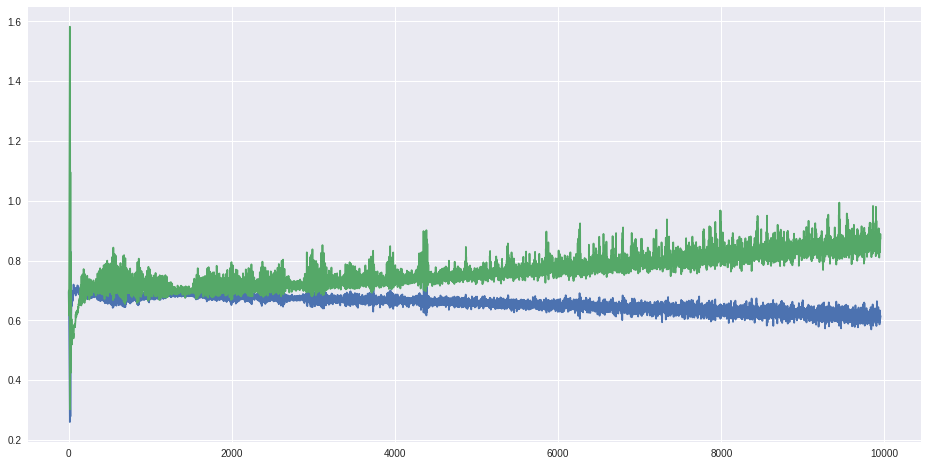

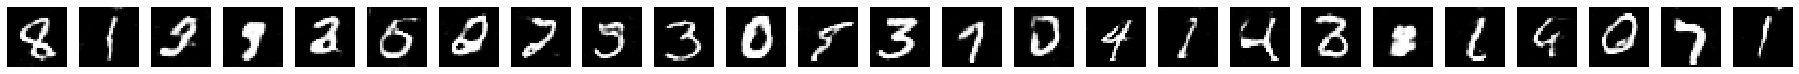

In [30]:
nbEpoch = 10000
dLoss = []
gLoss = []

from IPython.display import clear_output, Image

gan, discriminator, generator = dcganModels()

batchSize = 128

for epoch in range(nbEpoch):
  randomInput, trueImages, generatedImages = makeBatch(x_train)
  discriminatorLoss = 0.5 * (discriminator.train_on_batch(generatedImages, np.zeros(generatedImages.shape[0])) + discriminator.train_on_batch(trueImages, np.ones(trueImages.shape[0])))
  dcganLabels = np.ones(generatedImages.shape[0]).astype(int)			
  discriminator.trainable = False
  dcganLoss = gan.train_on_batch(randomInput, dcganLabels)
  discriminator.trainable = True
  dLoss.append(discriminatorLoss)
  gLoss.append(dcganLoss)
  
  if (epoch % 50 == 0) or (epoch == 0):
    print('after epoch: ', epoch)
    print ('dcgan Loss: ', dcganLoss, '\t discriminator loss', discriminatorLoss)
    clear_output(wait=True)
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(16, 8)
    ax1.plot(range(len(dLoss)), dLoss, label="loss generator")
    ax1.plot(range(len(gLoss)), gLoss, label="loss disc-true")
    plt.show()
    plotImages(generatedImages)
    tbl.logModel(logger, epoch, generator, "generator")
    tbl.logModel(logger, epoch, discriminator, "discriminator")
    logger.log_scalar('generator_loss', gLoss[epoch], epoch)
    logger.log_scalar('discriminator_loss', dLoss[epoch], epoch)